In [2]:
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = "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"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = "rag-app"

In [3]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("llama3.2", model_provider="ollama", base_url ="http://localhost:11434")

In [4]:
from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(model="llama3.2", base_url="http://localhost:11434")

In [5]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="rag-pipeline",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",
)

In [6]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [11]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

_ = vector_store.add_documents(documents=all_splits)

prompt = hub.pull("rlm/rag-prompt")

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [12]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

I don't know the definition of Task Decomposition in this context. However, based on general knowledge, task decomposition is a process of breaking down complex tasks into smaller, manageable sub-tasks that can be completed independently. This technique is used to simplify complex problems and make them more solvable.


In [13]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


In [14]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, 
    chunk_overlap=200,  
    add_start_index=True,  
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


In [15]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['14c7ea26-0679-4445-91cc-d7110731695a', 'e57bca06-a203-4fd3-8dbd-b51f574d0440', '2f380abd-36a2-4e5e-85ba-3180a70473c3']


In [16]:
from langchain import hub


prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [ ]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [ ]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [ ]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

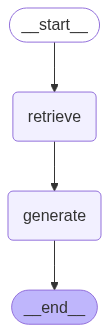

In [18]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='22e659c8-e089-4a3b-89ab-dc7241435c42', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Resources:\n1. Internet access for searches and information gathering.\n2. Long Term memory management.\n3. GPT-3.5 powered Agents for delegation of simple tasks.\n4. File output.\n\nPerformance Evaluation:\n1. Continuously review and analyze your actions to ensure you are performing to the best of your abilities.\n2. Constructively self-criticize your big-picture behavior constantly.\n3. Reflect on past decisions and strategies to refine your approach.\n4. Every command has a cost, so be smart and efficient. Aim to complete tasks in the least number of steps.'), Document(id='d2ec182d-d09d-4abb-846c-16af3cdc5927', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 29546}, page_content='Resources:\n1. Internet access for searches and information gathering.\n2. Long Term memory management.\n3. GPT-

In [19]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='22e659c8-e089-4a3b-89ab-dc7241435c42', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Resources:\n1. Internet access for searches and information gathering.\n2. Long Term memory management.\n3. GPT-3.5 powered Agents for delegation of simple tasks.\n4. File output.\n\nPerformance Evaluation:\n1. Continuously review and analyze your actions to ensure you are performing to the best of your abilities.\n2. Constructively self-criticize your big-picture behavior constantly.\n3. Reflect on past decisions and strategies to refine your approach.\n4. Every command has a cost, so be smart and efficient. Aim to complete tasks in the least number of steps.'), Document(id='d2ec182d-d09d-4abb-846c-16af3cdc5927', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 29546}, page_content='Resources:\n1. Internet access for searches and information gathering.\n2. Long Term memory mana

In [20]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

Task| Decom|position| is| a| process| of| breaking| down| complex| tasks| into| smaller|,| more| manageable| sub|-t|asks|.| It| involves| analyzing| the| task| requirements| and| identifying| the| key| components| that| need| to| be| addressed|.| By| decom|posing| large| tasks| into| smaller| ones|,| individuals| or| systems| can| improve| efficiency| and| effectiveness| in| completing| tasks|.||

In [21]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [22]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

In [23]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

In [25]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

In [26]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

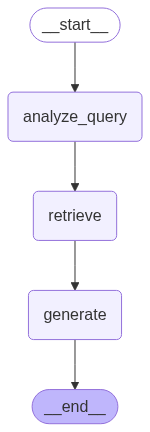

In [27]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='de2bf532-623b-4a08-a164-cf433243f3a6', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 39137, 'section': 'end'}, page_content='Finite context length: The restricted context capacity limits the inclusion of historical information, detailed instructions, API call context, and responses. The design of the system has to work with this limited communication bandwidth, while mechanisms like self-reflection to learn from past mistakes would benefit a lot from long or infinite context windows. Although vector stores and retrieval can provide access to a larger knowledge pool, their representation power is not as powerful as full attention.\n\n\nChallenges in long-term planning and task decomposition: Planning over a lengthy history and effectively exploring the solution space remain challenging. LLMs struggle to adj